<a href="https://colab.research.google.com/github/chltjs1921/2024_modeling_practice/blob/main/4_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.Make data

In [ ]:
import sklearn

In [ ]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(X[:5])
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [ ]:
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


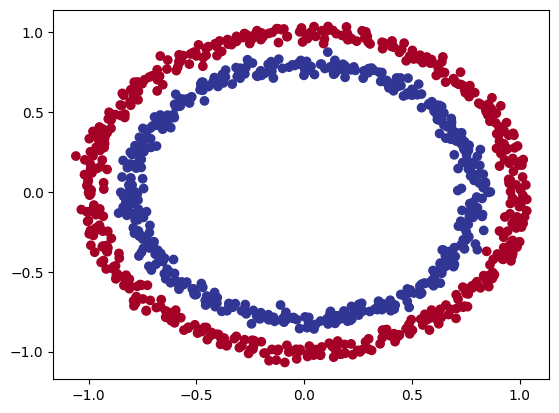

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
import torch
torch.__version__

'2.3.0+cu121'

In [ ]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [ ]:
X =torch.from_numpy(X).type(torch.float)
y =torch.from_numpy(y).type(torch.float)

In [ ]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

Bulid model

1. set device
2. model construct
3. define loss and optimizer
4. create train and test loop

In [ ]:
#1.set device
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu" #런타임 꼭 gpu로!!!
print(f"Using {device} device")

Using cuda device


In [ ]:
#2.model construct
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)


    def forward(self, x):
        return self.layer_2(torch.relu(self.layer_1(x)))

model_0 = CircleModelV0().to(device)

In [ ]:
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
device

'cuda'

In [ ]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [ ]:
model_0 = nn.Sequential(
    nn.Linear(2, 5),
    nn.Linear(5, 1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5012, -0.7036],
                      [ 0.6524, -0.1913],
                      [-0.2893, -0.1858],
                      [ 0.3596,  0.6042],
                      [ 0.0393, -0.0931]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.0268, -0.0602, -0.2203,  0.2803, -0.4616], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.3216, -0.0024,  0.1320,  0.2208, -0.0105]], device='cuda:0')),
             ('1.bias', tensor([-0.4096], device='cuda:0'))])

In [ ]:
with torch.inference_mode():
    untrained_pred = model_0(X_test.to(device))
len(untrained_pred), untrained_pred.shape, len(X_test), X_test.shape, torch.round(untrained_pred[:10]), y_test[:10]

(200,
 torch.Size([200, 1]),
 200,
 torch.Size([200, 2]),
 tensor([[-1.],
         [-0.],
         [-0.],
         [-1.],
         [-0.],
         [-0.],
         [-0.],
         [-0.],
         [-0.],
         [-0.]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

In [ ]:
#3. define loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [ ]:
#calculate accu
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, torch.round(y_pred)).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

Train model

1.Forward pass
2.Calculate loss
3.Optimizer zero grad
4.Loss backword(역전파)
5.Optimizer step(gradient descent)

In [ ]:
#1.Forward pass
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.5175],
        [-0.4714],
        [-0.4676],
        [-0.5324],
        [-0.1963]], device='cuda:0')

In [ ]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3734],
        [0.3843],
        [0.3852],
        [0.3700],
        [0.4511]], device='cuda:0')

In [ ]:
torch.round(y_pred_probs)
#logit>prob>label

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [ ]:
y_preds = torch.round(y_pred_probs)

y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

In [ ]:
#build loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    #forward pass
    model_0.train()
    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    #calculate loss, accu
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_preds)

    #Optimizer zero grad
    optimizer.zero_grad()

    #역전파
    loss.backward()

    #optimizer step
    optimizer.step()

    #Test
    model_0.eval()
    with torch.inference_mode():
        y_logits_test = model_0(X_test).squeeze()
        y_preds_test = torch.round(torch.sigmoid(y_logits_test))

        loss_test = loss_fn(y_logits_test, y_test)
        acc_test = accuracy_fn(y_test, y_preds_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.2f}%, Test loss: {loss_test:.4f}, Test accuracy: {acc_test:.2f}%")

Epoch: 0, Loss: 0.7123, Accuracy: 50.00%, Test loss: 0.7110, Test accuracy: 50.00%
Epoch: 10, Loss: 0.7028, Accuracy: 50.00%, Test loss: 0.7027, Test accuracy: 50.00%
Epoch: 20, Loss: 0.6982, Accuracy: 43.75%, Test loss: 0.6989, Test accuracy: 43.50%
Epoch: 30, Loss: 0.6959, Accuracy: 45.88%, Test loss: 0.6971, Test accuracy: 46.00%
Epoch: 40, Loss: 0.6948, Accuracy: 48.75%, Test loss: 0.6963, Test accuracy: 43.00%
Epoch: 50, Loss: 0.6941, Accuracy: 48.62%, Test loss: 0.6959, Test accuracy: 48.00%
Epoch: 60, Loss: 0.6938, Accuracy: 48.25%, Test loss: 0.6957, Test accuracy: 49.50%
Epoch: 70, Loss: 0.6936, Accuracy: 49.12%, Test loss: 0.6956, Test accuracy: 50.00%
Epoch: 80, Loss: 0.6934, Accuracy: 49.25%, Test loss: 0.6955, Test accuracy: 49.50%
Epoch: 90, Loss: 0.6933, Accuracy: 49.50%, Test loss: 0.6954, Test accuracy: 49.00%


In [ ]:
loss_fn

BCEWithLogitsLoss()

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

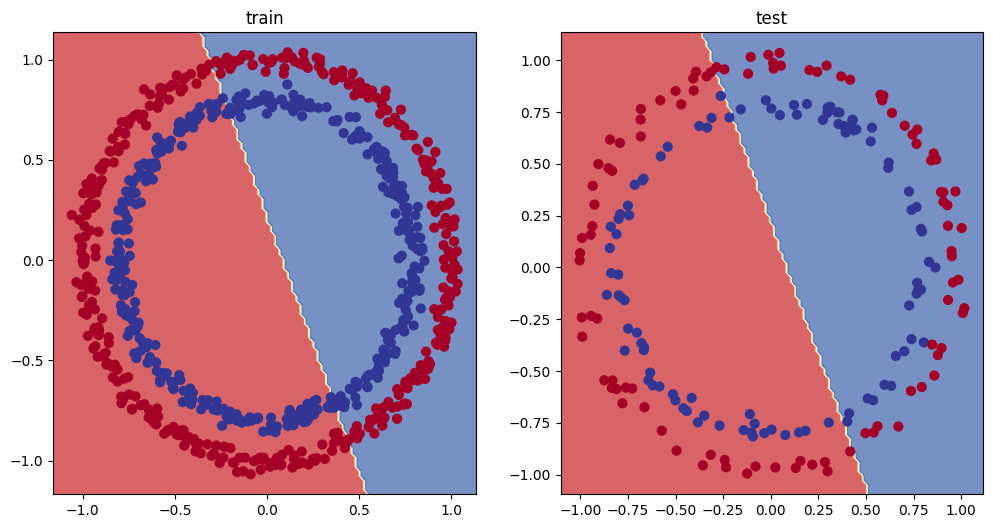

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('test')
plot_decision_boundary(model_0, X_test, y_test)

Improving model


*   Add more layers/hidden units
*   Fit for longer
*   Change activation function/learning rate/loss function








In [ ]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 10)
        self.layer_2 = nn.Linear(10, 10)
        self.layer_3 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    #forward pass
    model_1.train()
    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    #calculate loss, accu
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_preds)

    #Optimizer zero grad
    optimizer.zero_grad()

    #역전파
    loss.backward()

    #optimizer step
    optimizer.step()

    #Test
    model_1.eval()
    with torch.inference_mode():
        y_logits_test = model_1(X_test).squeeze()
        y_preds_test = torch.round(torch.sigmoid(y_logits_test))

        loss_test = loss_fn(y_logits_test, y_test)
        acc_test = accuracy_fn(y_test, y_preds_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.2f}%, Test loss: {loss_test:.4f}, Test accuracy: {acc_test:.2f}%")


Epoch: 0, Loss: 0.6940, Accuracy: 50.88%, Test loss: 0.6926, Test accuracy: 51.00%
Epoch: 100, Loss: 0.6937, Accuracy: 50.25%, Test loss: 0.6927, Test accuracy: 50.00%
Epoch: 200, Loss: 0.6935, Accuracy: 50.12%, Test loss: 0.6928, Test accuracy: 49.50%
Epoch: 300, Loss: 0.6934, Accuracy: 50.50%, Test loss: 0.6930, Test accuracy: 49.00%
Epoch: 400, Loss: 0.6933, Accuracy: 50.38%, Test loss: 0.6931, Test accuracy: 48.50%
Epoch: 500, Loss: 0.6932, Accuracy: 49.88%, Test loss: 0.6932, Test accuracy: 49.50%
Epoch: 600, Loss: 0.6932, Accuracy: 49.50%, Test loss: 0.6933, Test accuracy: 53.00%
Epoch: 700, Loss: 0.6931, Accuracy: 49.38%, Test loss: 0.6935, Test accuracy: 50.50%
Epoch: 800, Loss: 0.6931, Accuracy: 50.00%, Test loss: 0.6936, Test accuracy: 51.00%
Epoch: 900, Loss: 0.6931, Accuracy: 50.62%, Test loss: 0.6937, Test accuracy: 47.50%


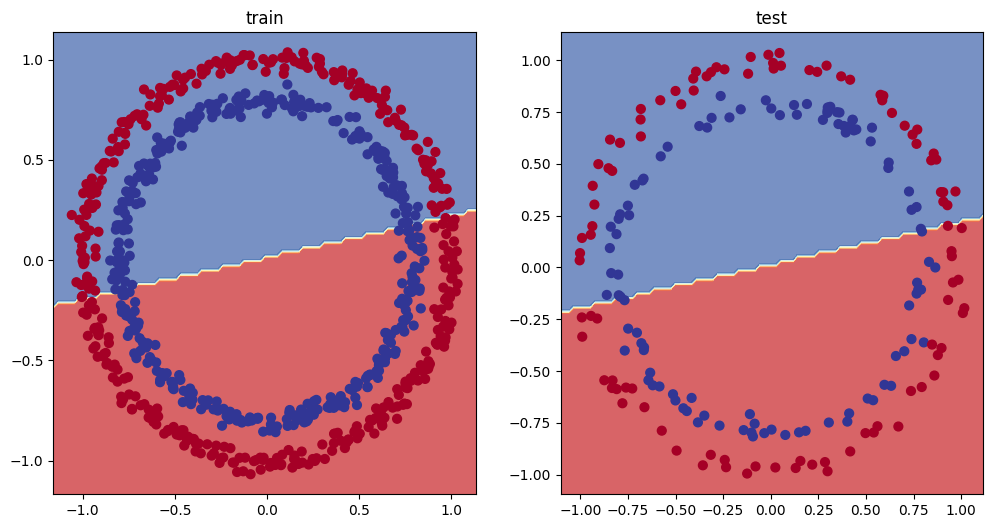

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('test')
plot_decision_boundary(model_1, X_test, y_test)

5.1 Preparing data to see if our model can fit a straight line  
작은 문제로 바꿔보기

In [ ]:
#Create data
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01
X_reg = torch.arange(start, end, step).unsqueeze(dim=1)
y_reg = weight * X_reg + bias

#check data
print(len(X_reg), len(y_reg))
print(X_reg[:5], y_reg[:5])

100 100
tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400]]) tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280]])


In [ ]:
#create train. test
train_split = int(0.8*len(X_reg))
X_train_reg, y_train_reg = X_reg[:train_split], y_reg[:train_split]
X_test_reg, y_test_reg = X_reg[train_split:], y_reg[train_split:]

len(X_train_reg), len(X_test_reg), len(y_train_reg), len(y_test_reg)

(80, 20, 80, 20)

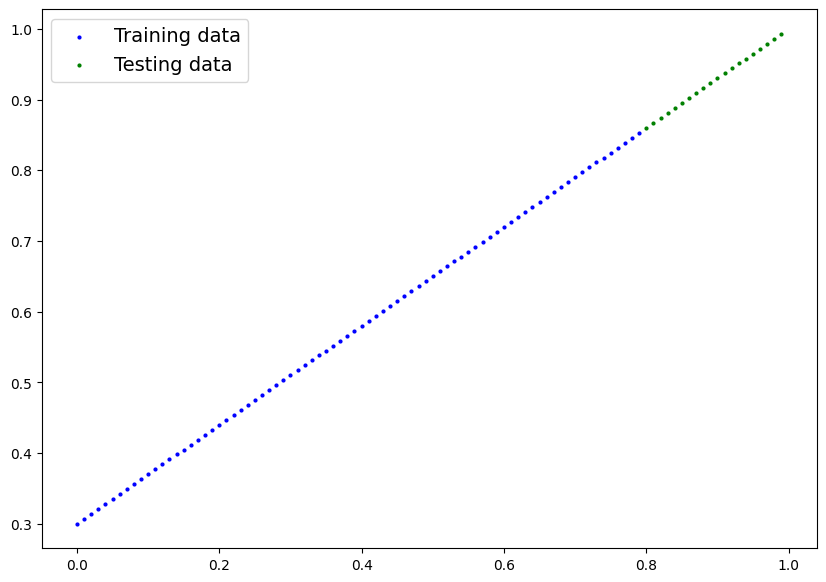

In [ ]:
plot_predictions(X_train_reg, y_train_reg, X_test_reg, y_test_reg)

5.2 위에서 만든 model adjust

In [ ]:
#same architecture but using nn.Sequential()
model2 = nn.Sequential(nn.Linear(in_features=1, out_features=10),
                       nn.Linear(in_features=10, out_features=10),
                       nn.Linear(in_features=10, out_features=1)).to(device)

model2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
#Loss, optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.01)

In [ ]:
#train model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1000

X_test_reg, y_test_reg = X_test_reg.to(device), y_test_reg.to(device)
X_train_reg, y_train_reg = X_train_reg.to(device), y_train_reg.to(device)

for epoch in range(epochs):
    y_pred_reg = model2(X_train_reg)
    loss = loss_fn(y_pred_reg, y_train_reg)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #test
    model2.eval()
    with torch.inference_mode():
        y_pred_reg_test = model2(X_test_reg)
        loss_test = loss_fn(y_pred_reg_test, y_test_reg)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.5f}, Test loss: {loss_test:.5f}")

Epoch: 0, Loss: 0.75986, Test loss: 0.91103
Epoch: 100, Loss: 0.02858, Test loss: 0.00081
Epoch: 200, Loss: 0.02533, Test loss: 0.00209
Epoch: 300, Loss: 0.02137, Test loss: 0.00305
Epoch: 400, Loss: 0.01964, Test loss: 0.00341
Epoch: 500, Loss: 0.01940, Test loss: 0.00387
Epoch: 600, Loss: 0.01903, Test loss: 0.00379
Epoch: 700, Loss: 0.01878, Test loss: 0.00381
Epoch: 800, Loss: 0.01840, Test loss: 0.00329
Epoch: 900, Loss: 0.01798, Test loss: 0.00360


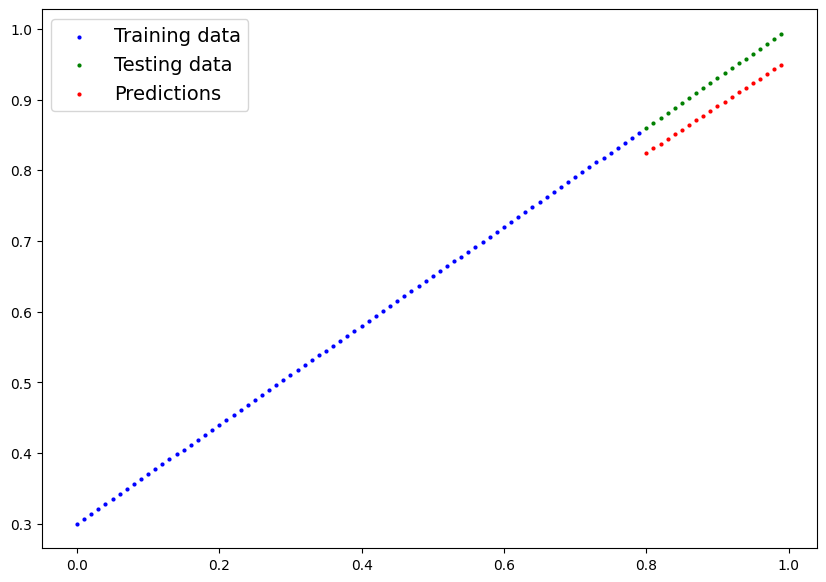

In [ ]:
#turn on evaluation mode
model2.eval()

with torch.inference_mode():
    y_pred_reg_test = model2(X_test_reg)

#plot
plot_predictions(X_train_reg.cpu(), y_train_reg.cpu(), X_test_reg.cpu(), y_test_reg.cpu(), y_pred_reg_test.cpu())

6. Non-linear

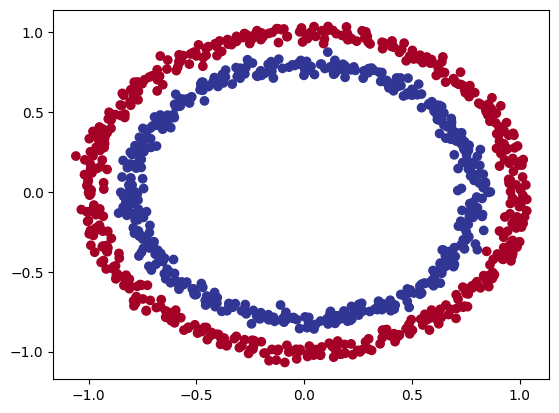

In [ ]:
#make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

In [ ]:
#convert data to tensors and split

import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

6.2 Buliding a model with non-linearity

In [ ]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)

In [ ]:
#setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.1)

6.3 train model

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_preds)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_preds)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.2f}%, Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.2f}%")

Epoch: 0, Loss: 0.6929, Accuracy: 50.00%, Test loss: 0.6939, Test accuracy: 50.00%
Epoch: 100, Loss: 0.0017, Accuracy: 100.00%, Test loss: 0.0074, Test accuracy: 100.00%
Epoch: 200, Loss: 0.0007, Accuracy: 100.00%, Test loss: 0.0054, Test accuracy: 100.00%
Epoch: 300, Loss: 0.0004, Accuracy: 100.00%, Test loss: 0.0049, Test accuracy: 100.00%
Epoch: 400, Loss: 0.0003, Accuracy: 100.00%, Test loss: 0.0057, Test accuracy: 100.00%
Epoch: 500, Loss: 0.0002, Accuracy: 100.00%, Test loss: 0.0052, Test accuracy: 100.00%
Epoch: 600, Loss: 0.0001, Accuracy: 100.00%, Test loss: 0.0051, Test accuracy: 100.00%
Epoch: 700, Loss: 0.0001, Accuracy: 100.00%, Test loss: 0.0053, Test accuracy: 100.00%
Epoch: 800, Loss: 0.0001, Accuracy: 100.00%, Test loss: 0.0056, Test accuracy: 100.00%
Epoch: 900, Loss: 0.0001, Accuracy: 100.00%, Test loss: 0.0058, Test accuracy: 100.00%


6.4 Evaluate model

In [ ]:
model_3.eval()
with torch.inference_mode():
    y_logits = model_3(X_test).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

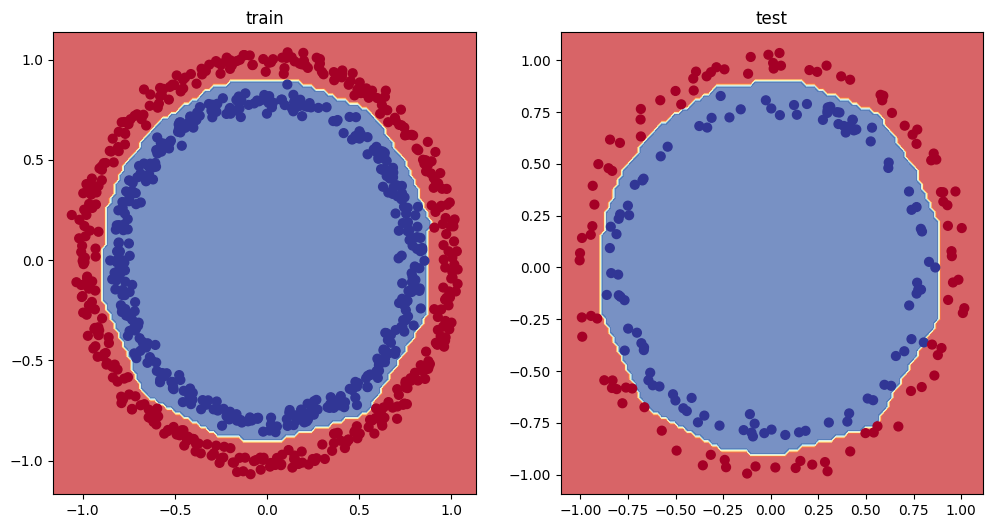

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('train')
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('test')
plot_decision_boundary(model_3, X_test, y_test)
plt.show()

7. Replicate non-linear activation function

In [ ]:
#create tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

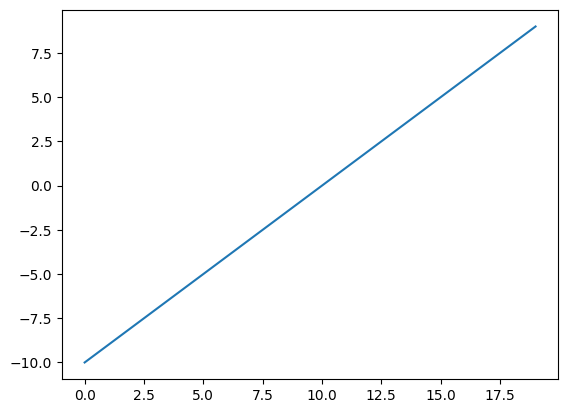

In [ ]:
plt.plot(A)
plt.show()

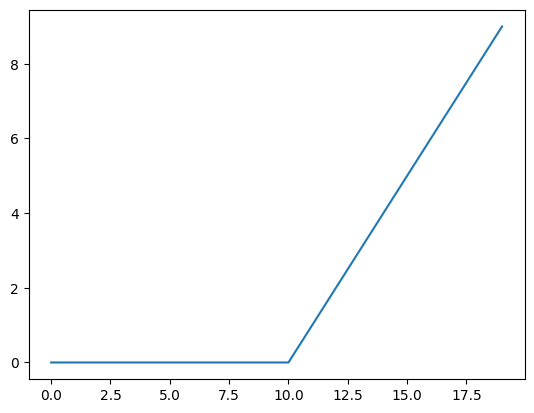

In [ ]:
plt.plot(torch.relu(A))
plt.show()

In [ ]:
def relu(x):
    return torch.max(torch.tensor(0), x)

In [ ]:
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

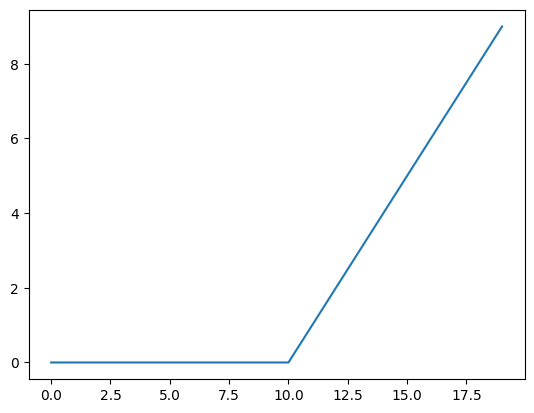

In [ ]:
plt.plot(relu(A))
plt.show()

In [ ]:
def sig(x):
    return 1 / (1 + torch.exp(-x))

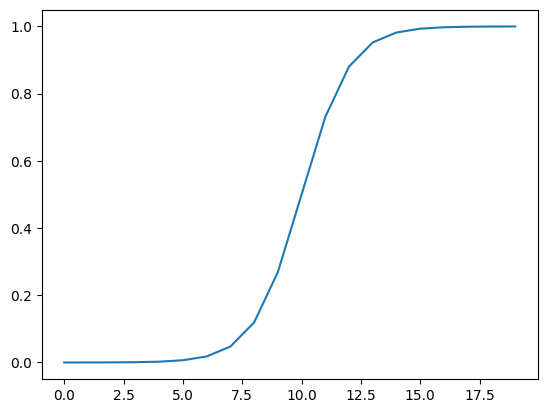

In [ ]:
plt.plot(torch.sigmoid(A))
plt.show()

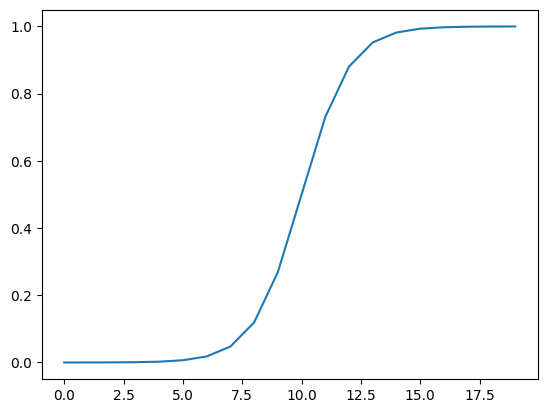

In [ ]:
plt.plot(sig(A))
plt.show()

8. multi-class

8.1 Create toy multi-class dataset

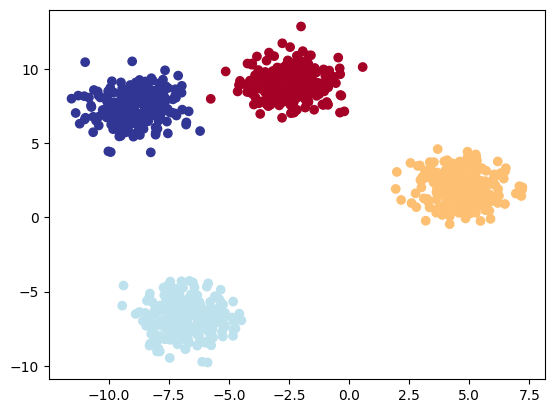

In [ ]:
from sklearn.datasets import make_blobs

X_blob, y_blob = make_blobs(n_samples=1000, n_features=2, centers=4, random_state=42)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=42)

plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)
plt.show()

8.2 Bulig a multiclass classification model in Pytorch

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_stack(x)

model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.1)

8.3 Train model

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

#logit>prob>index

for epoch in range(epochs):
    model_4.train()

    y_blob_logits = model_4(X_blob_train)
    y_blob_preds = torch.softmax(y_blob_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_blob_logits, y_blob_train)
    acc = accuracy_fn(y_blob_train, y_blob_preds)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_blob_test, test_preds)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.2f}%, Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.2f}%")

Epoch: 0, Loss: 1.1523, Accuracy: 38.62%, Test loss: 0.7923, Test accuracy: 71.00%
Epoch: 100, Loss: 0.0002, Accuracy: 100.00%, Test loss: 0.0000, Test accuracy: 100.00%
Epoch: 200, Loss: 0.0001, Accuracy: 100.00%, Test loss: 0.0000, Test accuracy: 100.00%
Epoch: 300, Loss: 0.0001, Accuracy: 100.00%, Test loss: 0.0000, Test accuracy: 100.00%
Epoch: 400, Loss: 0.0000, Accuracy: 100.00%, Test loss: 0.0000, Test accuracy: 100.00%
Epoch: 500, Loss: 0.0000, Accuracy: 100.00%, Test loss: 0.0000, Test accuracy: 100.00%
Epoch: 600, Loss: 0.0000, Accuracy: 100.00%, Test loss: 0.0000, Test accuracy: 100.00%
Epoch: 700, Loss: 0.0000, Accuracy: 100.00%, Test loss: 0.0000, Test accuracy: 100.00%
Epoch: 800, Loss: 0.0000, Accuracy: 100.00%, Test loss: 0.0000, Test accuracy: 100.00%
Epoch: 900, Loss: 0.0000, Accuracy: 100.00%, Test loss: 0.0000, Test accuracy: 100.00%


8.4 Evaluate model

In [ ]:
model_4.eval()
with torch.inference_mode():
    y_blob_logits = model_4(X_blob_test)
    y_blob_preds = torch.softmax(y_blob_logits, dim=1).argmax(dim=1)

    print(y_blob_preds[:10])

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')


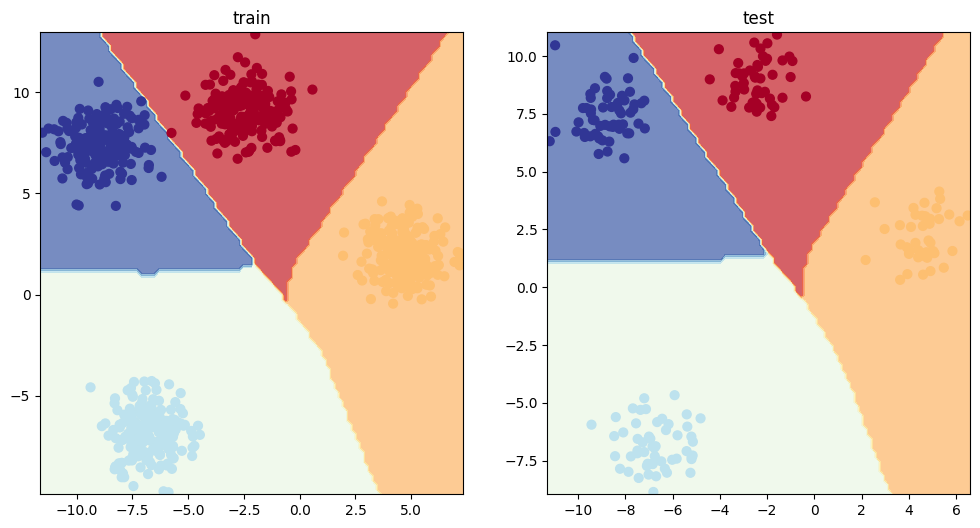

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('train')
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title('test')
plot_decision_boundary(model_4, X_blob_test, y_blob_test)
plt.show()

8.5 Few more metrics

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 11.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [ ]:
from torchmetrics import Accuracy

accuracy_fn = Accuracy(task="multiclass", num_classes=4).to(device)
accuracy_fn(y_blob_preds, y_blob_test)

tensor(1., device='cuda:0')